<a href="https://www.kaggle.com/code/yaseredkina/santa-s-2024-puzzle-sy?scriptVersionId=227243043" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/santa-2024/sample_submission.csv', delimiter=',', encoding='utf-8')

# Display first few rows and all columns
pd.set_option('display.max_columns', None)

df.head(6)

,id,text
0,0,advent chimney elf family fireplace gingerbrea...
1,1,advent chimney elf family fireplace gingerbrea...
2,2,yuletide decorations gifts cheer holiday carol...
3,3,yuletide decorations gifts cheer holiday carol...
4,4,hohoho candle poinsettia snowglobe peppermint ...
5,5,advent chimney elf family fireplace gingerbrea...


# **Data Cleaning**

Check for missing values

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
id      0
text    0
dtype: int64


In [4]:
# Clean dataset by dropping rows with missing values (if any)
df_cleaned = df.dropna()

print("\nCleaned Dataset Overview:")
print(df_cleaned.head())


Cleaned Dataset Overview:
   id                                               text
0   0  advent chimney elf family fireplace gingerbrea...
1   1  advent chimney elf family fireplace gingerbrea...
2   2  yuletide decorations gifts cheer holiday carol...
3   3  yuletide decorations gifts cheer holiday carol...
4   4  hohoho candle poinsettia snowglobe peppermint ...


In [5]:
# Display the DataFrame without the index using pandas Styler
df_cleaned = df.head(6)
df_cleaned.style.hide(axis='index')

id,text
0,advent chimney elf family fireplace gingerbread mistletoe ornament reindeer scrooge
1,advent chimney elf family fireplace gingerbread mistletoe ornament reindeer scrooge walk give jump drive bake the sleep night laugh and
2,yuletide decorations gifts cheer holiday carol magi nutcracker polar grinch sleigh chimney workshop stocking ornament holly jingle beard naughty nice
3,yuletide decorations gifts cheer holiday carol magi nutcracker polar grinch sleigh chimney workshop stocking ornament holly jingle beard naughty nice sing cheer and of the is eat visit relax unwrap
4,hohoho candle poinsettia snowglobe peppermint eggnog fruitcake chocolate candy puzzle game doll toy workshop wonder believe dream hope peace joy merry season greeting card wrapping paper bow fireplace night cookie milk star wish wreath angel the to of and in that have it not with as you from we kaggle
5,advent chimney elf family fireplace gingerbread mistletoe ornament reindeer scrooge walk give jump drive bake the sleep night laugh and yuletide decorations gifts cheer holiday carol magi nutcracker polar grinch sleigh chimney workshop stocking ornament holly jingle beard naughty nice sing cheer and of the is eat visit relax unwrap hohoho candle poinsettia snowglobe peppermint eggnog fruitcake chocolate candy puzzle game doll toy workshop wonder believe dream hope peace joy merry season greeting card wrapping paper bow fireplace night cookie milk star wish wreath angel the to of and in that have it not with as you from we kaggle


# **Word count**

Analyze how the word count is distributed across all texts (or sequences). This helps identify patterns in the dataset and understand the average text length, as well as how texts vary in length.

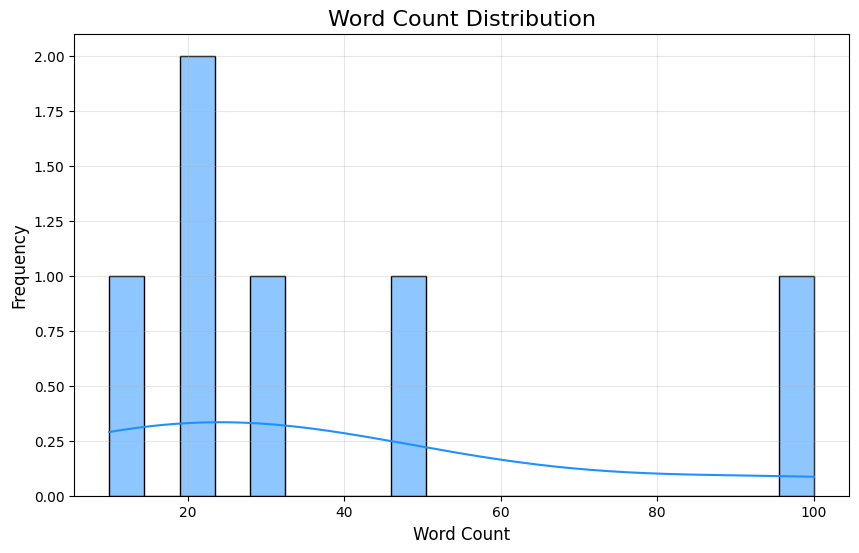

   id                                               text  word_count
0   0  advent chimney elf family fireplace gingerbrea...          10
1   1  advent chimney elf family fireplace gingerbrea...          20
2   2  yuletide decorations gifts cheer holiday carol...          20
3   3  yuletide decorations gifts cheer holiday carol...          30
4   4  hohoho candle poinsettia snowglobe peppermint ...          50
5   5  advent chimney elf family fireplace gingerbrea...         100


In [6]:
# Ignore FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Create a copy of the DataFrame
df_cleaned = df_cleaned.copy()

# Add a column with the word count
df_cleaned['word_count'] = df_cleaned['text'].apply(lambda x: len(str(x).split()))

# Plot histogram of word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['word_count'], bins=20, kde=True, color='dodgerblue')
plt.title('Word Count Distribution', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

# Display DataFrame with the added word_count column
print(df_cleaned)

# <b>Word Frequency Heatmap</b>

Helps to understand how diverse the sequences are in terms of text length. For example, you can identify whether short or long texts dominate. Visualization helps detect anomalies or outliers, such as texts with too few or too many words.

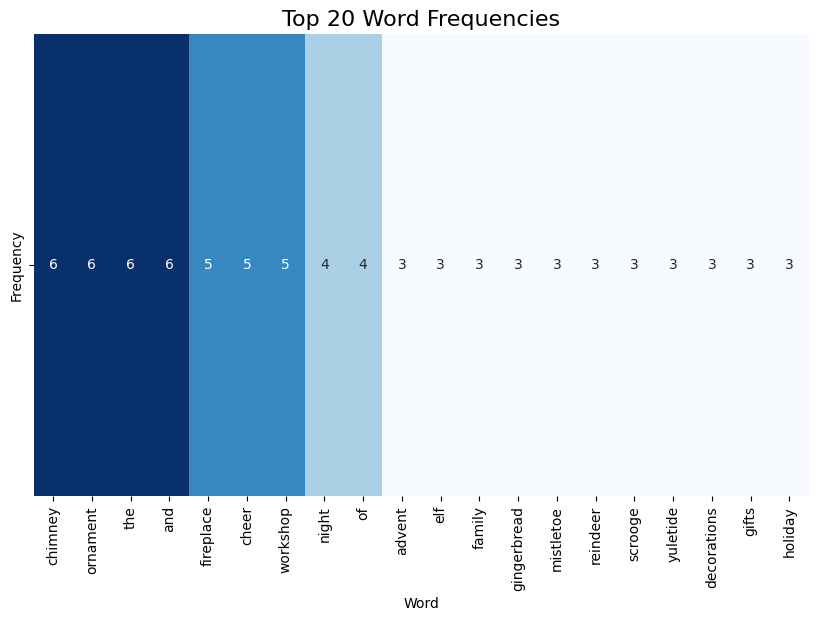

In [7]:
from collections import Counter
from wordcloud import WordCloud

# Count word frequencies
all_words = ' '.join(df_cleaned['text']).split()
word_freq = Counter(all_words)
top_words = word_freq.most_common(20)

# Create a DataFrame for visualization
word_freq_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(word_freq_df.set_index('Word').T, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Top 20 Word Frequencies', fontsize=16)
plt.show()


# <b>Sequence Length vs ID</b>

Helps to identify trends or patterns in the distribution of sequence lengths. For example, it can reveal whether there is a relationship between the text length and the record’s index.

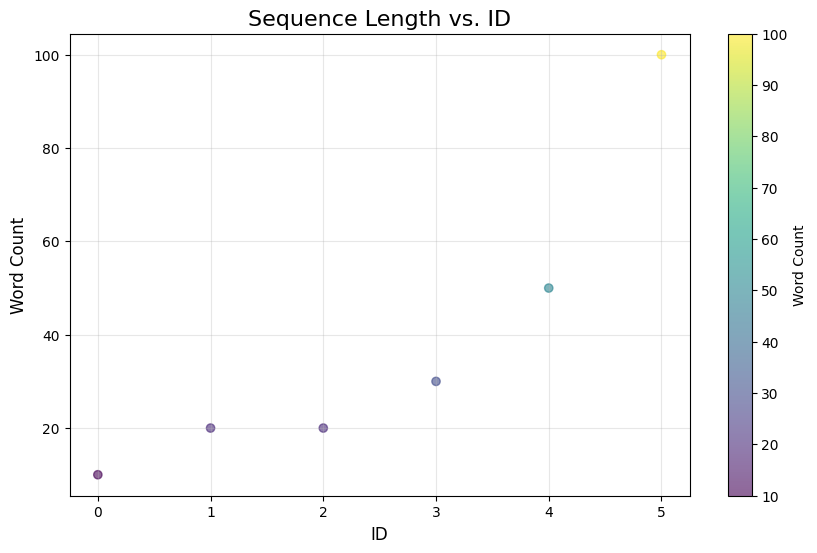

In [8]:
# Plot sequence length vs. ID
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['id'], df_cleaned['word_count'], alpha=0.6, c=df_cleaned['word_count'], cmap='viridis')
plt.colorbar(label='Word Count')
plt.title('Sequence Length vs. ID', fontsize=16)
plt.xlabel('ID', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.grid(alpha=0.3)
plt.show()


# **Text Length Distribution by Record Index**

This chart helps to identify whether there is a trend or pattern in the distribution of text lengths across record indices.

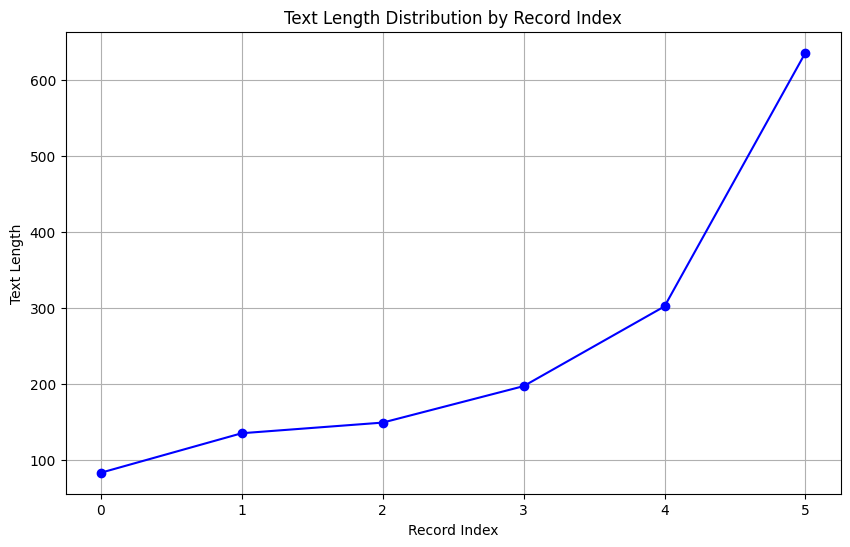

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a column for text length
df_cleaned['text_length'] = df_cleaned['text'].apply(len)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(df_cleaned.index, df_cleaned['text_length'], marker='o', linestyle='-', color='b')
plt.title('Text Length Distribution by Record Index')
plt.xlabel('Record Index')
plt.ylabel('Text Length')
plt.grid(True)
plt.show()

# **Network Graph for Analyzing Word Connections (Co-occurrence)**

The network graph helps to understand the content of the text by revealing how frequently certain words appear together. By visualizing co-occurring word pairs (bigrams), it identifies common phrases, recurring topics, and semantic relationships between words. This analysis uncovers underlying patterns, such as frequently used expressions or key themes, providing insights into the structure and context of the text.

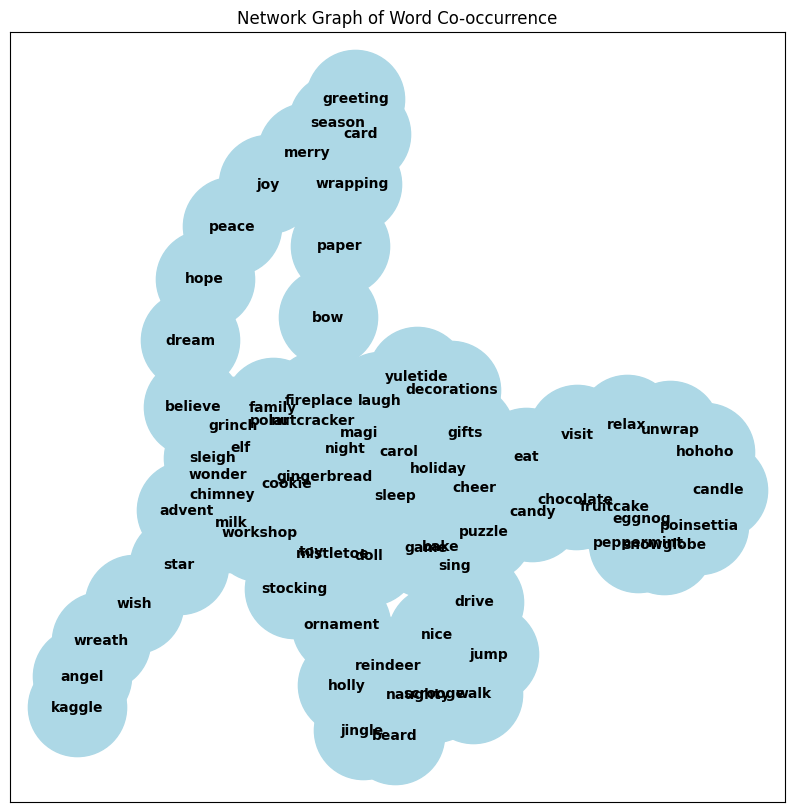

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Transform the text into bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df_cleaned['text'])

# Get the bigrams
bigrams = vectorizer.get_feature_names_out()

# Build the graph
G = nx.Graph()

# Add edges with weights, where weights represent the number of co-occurrences of the bigrams
for i, row in enumerate(X.toarray()):
    for j, count in enumerate(row):
        if count > 0:
            bigram = bigrams[j]
            G.add_edge(bigram.split()[0], bigram.split()[1], weight=count)

# Visualize the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_size=5000, node_color='lightblue', font_size=10, font_weight='bold')
plt.title('Network Graph of Word Co-occurrence')
plt.show()

# **Calculating input perplexity**

Calculating the perplexity for the input data to later compare it with other models or approaches.

In [11]:
!pip install transformers

In [12]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# Load the GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# Set eos_token as pad_token
tokenizer.pad_token = tokenizer.eos_token

# Function to calculate perplexity
def calculate_perplexity(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    input_ids = inputs["input_ids"]
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        perplexity = torch.exp(loss)
    return perplexity.item()

# List to store perplexity values
raw_perplexity_score = []
# Рассчитываем перплексию для всех текстов и записываем в список
df['score'] = df['text'].map(lambda x: calculate_perplexity(x))

# Записываем значения в raw_perplexity_score
raw_perplexity_score = df['score'].tolist()


# Печать значений перплексии
print("Raw Perplexity Scores:")
print(raw_perplexity_score)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Raw Perplexity Scores:
[475.3303527832031, 1069.6861572265625, 1261.548583984375, 1611.7296142578125, 681.3268432617188, 613.0409545898438]


#  **Searching for the Best Permutations Based on Perplexity**
Apply GPT-2 and then calculate perplexity to find the best permutations with good perplexity scores
I changed the number of permutations from 10 to 30, selecting the optimal one to avoid Kaggle disqualification


In [13]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import itertools

# Ignore FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Load GPT-2 model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()  # Set to evaluation mode

# Function to calculate perplexity
def calculate_perplexity(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    input_ids = inputs["input_ids"]
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        # Perplexity = exponentiation of the loss
        perplexity = torch.exp(loss)
    return perplexity.item()

# Function to generate all possible permutations of the text
def generate_permutations(text, max_samples=50):
    words = text.split()  # Split the text into words
    if len(words) > 11:  # If the text length is > 11, limit the number of permutations
        words = words[:11]  # Keep only the first 11 words
    all_permutations = list(itertools.permutations(words))  # Generate all permutations
    permuted_texts = [" ".join(p) for p in all_permutations]
    return permuted_texts[:max_samples]  # Limit the number of permutations

# Function to select the best permutation based on perplexity
def select_best_permutation(sequence, max_samples=50):
    permutations = generate_permutations(sequence, max_samples)
    perplexities = [calculate_perplexity(seq) for seq in permutations]
    best_idx = perplexities.index(min(perplexities))  # Find the index with the minimum perplexity
    return permutations[best_idx], min(perplexities)

# Read data from CSV file
df = pd.read_csv('/kaggle/input/santa-2024/sample_submission.csv', delimiter=',', encoding='utf-8')

# Lists to store results
best_sequences = []
best_perplexities = []

# Process each row in the DataFrame
for index, row in df.iterrows():
    original_text = row["text"]  # Get the text from the DataFrame
    if pd.isna(original_text) or not original_text.strip():  # Skip empty rows
        continue
    
    best_sequence, best_perplexity = select_best_permutation(original_text)
    
    # Save the results
    best_sequences.append(best_sequence)
    best_perplexities.append(best_perplexity)

# Add results to the DataFrame
df['best_sequence'] = best_sequences
df['best_perplexity'] = best_perplexities

# Display the first few rows for verification
df.head(6)

,id,text,best_sequence,best_perplexity
0,0,advent chimney elf family fireplace gingerbrea...,advent chimney elf family fireplace gingerbrea...,374.693665
1,1,advent chimney elf family fireplace gingerbrea...,advent chimney elf family fireplace gingerbrea...,404.831299
2,2,yuletide decorations gifts cheer holiday carol...,yuletide decorations gifts cheer holiday carol...,1540.338501
3,3,yuletide decorations gifts cheer holiday carol...,yuletide decorations gifts cheer holiday carol...,1540.338501
4,4,hohoho candle poinsettia snowglobe peppermint ...,hohoho candle poinsettia snowglobe peppermint ...,259.840912
5,5,advent chimney elf family fireplace gingerbrea...,advent chimney elf family fireplace gingerbrea...,404.831299


In [14]:
print (best_perplexities)

[374.69366455078125, 404.831298828125, 1540.3385009765625, 1540.3385009765625, 259.8409118652344, 404.831298828125]


# **Row-by-Row Comparison of Raw Perplexity vs Best Perplexity** 

Bar plot provides a side-by-side comparison of the raw perplexity scores and best perplexity scores for each corresponding data point. Each pair of bars represents the perplexity scores for the same text sequence — one bar for the raw score and one for the best score after permutation.

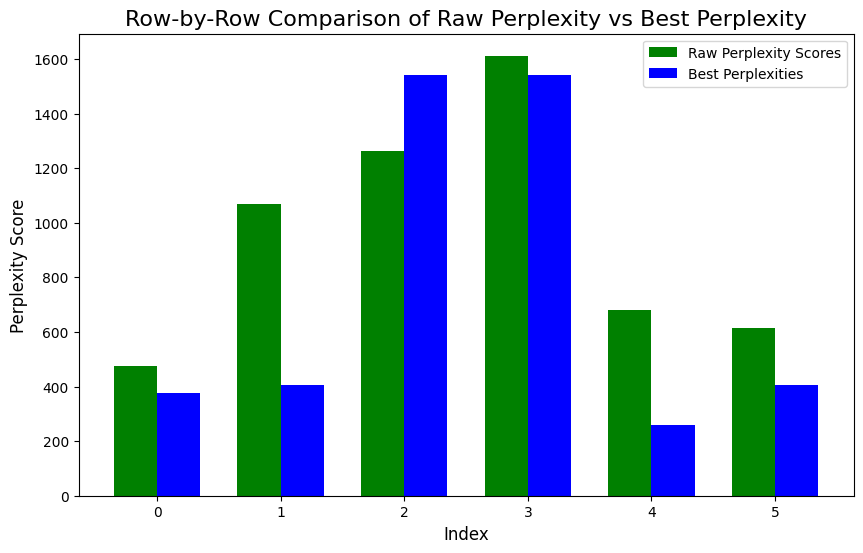

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create an array of indices for the comparison
indices = np.arange(len(raw_perplexity_score))

# Set up the figure and axis
plt.figure(figsize=(10, 6))

# Create bar plot for Raw Perplexity and Best Perplexity side by side
bar_width = 0.35  # width of the bars
plt.bar(indices - bar_width/2, raw_perplexity_score, bar_width, label='Raw Perplexity Scores', color='green')
plt.bar(indices + bar_width/2, best_perplexities, bar_width, label='Best Perplexities', color='blue')

# Adding labels, title, and legend
plt.xlabel('Index', fontsize=12)
plt.ylabel('Perplexity Score', fontsize=12)
plt.title('Row-by-Row Comparison of Raw Perplexity vs Best Perplexity', fontsize=16)
plt.xticks(indices)  # Set the x-axis ticks to the indices
plt.legend()

# Show the plot
plt.show()

# **Improving perplexity**

Code processes text data by generating weighted permutations of words, taking into account their frequency and context. 

Instead of simply generating random permutations, the words are sorted by their frequency to optimize their order, aiming for more meaningful and coherent text. 

The number of permutations is limited to a maximum of 50, focusing on generating contextually relevant options rather than all possible arrangements. 

This approach allows for faster perplexity calculations and reduces computational load, while ensuring the generated permutations are more likely to produce logically coherent results.

In [16]:
import random
import pandas as pd
from collections import Counter

# Function to generate valid permutations of the original words
def generate_weighted_permutations(text, max_samples=50):
    words = text.split()  # Split the text into words
    
    # Analyze word frequency
    word_counts = Counter(words)
    # Sort words by frequency (optional for weighted shuffling)
    sorted_words = sorted(words, key=lambda word: word_counts[word], reverse=True)
    
    permuted_texts = []
    # Generate a limited number of permutations
    for _ in range(max_samples):
        random.shuffle(sorted_words)  # Shuffle the words
        permuted_texts.append(" ".join(sorted_words))
    
    return permuted_texts

# Function to select the best permutation based on perplexity
def select_best_permutation_with_filtering(sequence, max_samples=50):
    permutations = generate_weighted_permutations(sequence, max_samples)
    
    # Calculate perplexity for each permutation
    perplexities = [calculate_perplexity(seq) for seq in permutations]
    
    # Select the permutation with the lowest perplexity
    best_idx = perplexities.index(min(perplexities))
    return permutations[best_idx], min(perplexities)

# Reading data from a CSV file
df = pd.read_csv('/kaggle/input/santa-2024/sample_submission.csv', delimiter=',', encoding='utf-8')

# Lists to store results
new_best_sequences = []
new_best_perplexities = []

# Processing each row in the DataFrame
for index, row in df.iterrows():
    original_text = row["text"]  # Get the text from the DataFrame
    if pd.isna(original_text) or not original_text.strip():  # Skip empty rows
        continue
    
    new_best_sequence, new_best_perplexity = select_best_permutation_with_filtering(original_text)
    
    # Save the results
    new_best_sequences.append(new_best_sequence)
    new_best_perplexities.append(new_best_perplexity)

# Adding results to the DataFrame
df['new_best_sequence'] = new_best_sequences
df['new_best_perplexity'] = new_best_perplexities

In [17]:
# DataFrame for comparison perplexities
comparison_df = pd.DataFrame({
    'Raw Perplexity': raw_perplexity_score,
    'Best Perplexity': best_perplexities,
    'New Best Perplexity': new_best_perplexities
})

# Display the table
print(comparison_df)

   Raw Perplexity  Best Perplexity  New Best Perplexity
0      475.330353       374.693665           258.266327
1     1069.686157       404.831299           751.511536
2     1261.548584      1540.338501           702.392883
3     1611.729614      1540.338501          1091.577271
4      681.326843       259.840912           901.139771
5      613.040955       404.831299           739.663574


# Row-by-Row Comparison of Raw Perplexity, Best Perplexity, New Best Perplexity


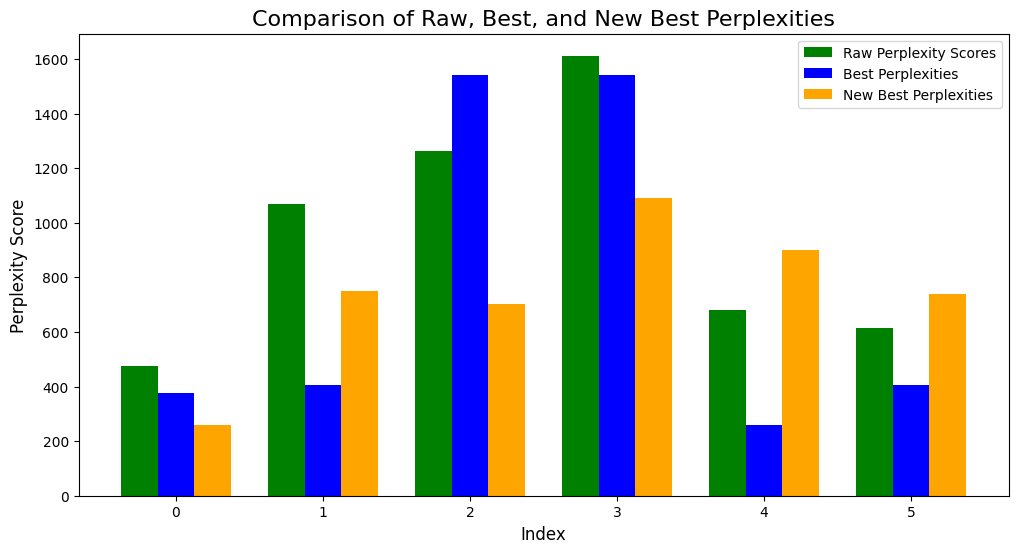

   Raw Perplexity  Best Perplexity  New Best Perplexity
0      475.330353       374.693665           258.266327
1     1069.686157       404.831299           751.511536
2     1261.548584      1540.338501           702.392883
3     1611.729614      1540.338501          1091.577271
4      681.326843       259.840912           901.139771
5      613.040955       404.831299           739.663574


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming these variables are already defined: raw_perplexity_score, best_perplexities, new_best_perplexities

# Create an array of indices for the comparison
indices = np.arange(len(raw_perplexity_score))

# Set up the figure and axis
plt.figure(figsize=(12, 6))

# Width of each bar
bar_width = 0.25

# Create bar plots for Raw Perplexity, Best Perplexity, and New Best Perplexity
plt.bar(indices - bar_width, raw_perplexity_score, bar_width, label='Raw Perplexity Scores', color='green')
plt.bar(indices, best_perplexities, bar_width, label='Best Perplexities', color='blue')
plt.bar(indices + bar_width, new_best_perplexities, bar_width, label='New Best Perplexities', color='orange')

# Adding labels, title, and legend
plt.xlabel('Index', fontsize=12)
plt.ylabel('Perplexity Score', fontsize=12)
plt.title('Comparison of Raw, Best, and New Best Perplexities', fontsize=16)
plt.xticks(indices)  # Set the x-axis ticks to the indices
plt.legend()

# Show the plot
plt.show()

# DataFrame for comparison perplexities
comparison_df = pd.DataFrame({
    'Raw Perplexity': raw_perplexity_score,
    'Best Perplexity': best_perplexities,
    'New Best Perplexity': new_best_perplexities
})

# Display the table
print(comparison_df)

# **Submission**


In [19]:
# Prepare the submission DataFrame with 'id' and 'new_best_sequence' columns
submission = df[['id', 'new_best_sequence']].copy()  # .copy() ensures you're working on a new DataFrame

# Rename the 'new_best_sequence' column to 'text'
submission = submission.rename(columns={'new_best_sequence': 'text'})

# Saving the submission to a CSV file
submission.to_csv('submission.csv', index=False)

In [20]:
# adjusting display options
pd.set_option('display.max_colwidth', None)
submission

,id,text
0,0,family elf scrooge reindeer ornament gingerbread chimney fireplace mistletoe advent
1,1,walk the mistletoe bake sleep chimney jump fireplace gingerbread ornament night reindeer scrooge elf advent laugh drive give and family
2,2,decorations jingle cheer carol chimney sleigh yuletide workshop nice magi polar ornament nutcracker gifts naughty beard holiday holly stocking grinch
3,3,holiday and eat cheer relax gifts ornament unwrap beard visit of decorations yuletide stocking holly grinch jingle sing carol magi chimney naughty nutcracker the cheer polar sleigh nice workshop is
4,4,doll toy angel peppermint and paper kaggle game star chocolate peace card wish night workshop greeting dream cookie it that with fruitcake have season wrapping candy of joy merry you candle from poinsettia as fireplace snowglobe believe puzzle in hohoho we milk the wonder eggnog bow not hope wreath to
5,5,cookie relax doll eat ornament wish bake it the unwrap chimney ornament nutcracker with stocking merry wreath angel polar nice visit chocolate fireplace from and mistletoe night candle beard in sleep peppermint that drive advent candy carol give dream chimney workshop cheer is you season card holly we as scrooge holiday cheer workshop wonder jingle and snowglobe hope eggnog decorations have puzzle bow toy of grinch naughty sleigh gifts jump greeting fruitcake sing kaggle peace the family gingerbread reindeer laugh hohoho poinsettia fireplace joy yuletide night believe and magi star milk of paper not elf wrapping to game the walk
